<a href="https://colab.research.google.com/github/xbadiam/Portfolio/blob/main/Credit_card_customers/CustomerChurnPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1.1 Contexto

Un gerente del banco está preocupado porque cada vez más clientes están dejando sus servicios de tarjetas de crédito. Apreciarían mucho si alguien pudiera predecir quiénes van a darse de baja, de modo que puedan actuar proactivamente, acercarse al cliente, ofrecerle mejores servicios y lograr que cambie de opinión.

Obtuve este conjunto de datos de un sitio web con la URL https://leaps.analyttica.com/home. He estado usándolo durante un tiempo para conseguir datasets y trabajar con ellos para obtener resultados útiles. El sitio explica cómo resolver un problema empresarial específico.

Este conjunto de datos consiste en información de 10,000 clientes, incluyendo su edad, salario, estado civil, límite de la tarjeta de crédito, categoría de la tarjeta, etc. Hay aproximadamente 18 características.

Solo el 16.07% de los clientes han cancelado el servicio. Por lo tanto, es un poco difícil entrenar nuestro modelo para predecir qué clientes se darán de baja.

### 1.2. Descripción de los datos

* **CLIENTNUM**: Número de cliente. Identificador único para los clientes que poseen la cuenta.
* **Attrition_Flag**: Variable de evento interno (actividad del cliente): si la cuenta está cerrada, entonces 1, de lo contrario 0.
* **Customer Age**: Edad de los clientes en años.
* **Gender**: VAriable sexo M=Male, F=Female.
* **Dependent_count**: Número de dependientes (familiares)
* **Education_Level**: Calificación educativa del titular de la cuenta (ejemplo: escuela secundaria, graduado universitario, etc.).
* **Marital_Status**: Casado, Soltero, Divorciado, Desconocido.
* **Income_Category**: Categoría de ingresos anuales del titular de la cuenta.
* **Card_Category**: Tipo de tarjeta (Azul, Plata, Oro, Platino).
* **Month_on_book**: Periodo de relación con el banco
* **Months_Inactive_12_mon**: Representa la cantidad de meses inactivo en el ultimo año

In [1]:
! git clone https://github.com/xbadiam/Portfolio.git

Cloning into 'Portfolio'...
remote: Enumerating objects: 194, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 194 (delta 9), reused 0 (delta 0), pack-reused 162 (from 1)
Receiving objects: 100% (194/194), 15.36 MiB | 11.24 MiB/s, done.
Resolving deltas: 100% (73/73), done.


## 2. Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance

# Métricas
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc

# Transformador
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer




## 3. Funciones especiales

In [3]:

def getTotalCountAndLabelFromValueFeatureByGroup(feature):
  count = data_copy[feature].value_counts()
  label = data_copy[feature].value_counts().index.tolist()
  return count, label

# Divide el conjunto de datos en tres subconjuntos: Entrenamiento, validación y text
def train_val_test_split(df, rstate=42, shuffle=True, stratify=None):
    strat = df[stratify] if stratify else None
    train_set, test_set = train_test_split(
        df, test_size=0.4, random_state=rstate, shuffle=shuffle, stratify=strat)
    strat = test_set[stratify] if stratify else None
    val_set, test_set = train_test_split(
        test_set, test_size=0.5, random_state=rstate, shuffle=shuffle, stratify=strat)
    return (train_set, val_set, test_set)

def evaluate_result(y_pred, y, y_prep_pred, y_prep, metric):
    print(metric.__name__, "WITHOUT preparation:", metric(y_pred, y, average='weighted'))
    print(metric.__name__, "WITH preparation:", metric(y_prep_pred, y_prep, average='weighted'))


## 4. Lectura de los datos


In [4]:
data = pd.read_csv('/content/Portfolio/Credit_card_customers/BankChurners.csv')
data = data[data.columns[:-2]]
data.head()


,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


## 5. Exploración de los datos

### 5.1. Resumen de los datos

In [5]:
# Realizamos una copia del conjunto de datos
data_copy = data.copy()

# Mostrar en pantalla un número determinado de filas
data_copy.head(5)

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [6]:
data_copy.shape

(10127, 21)

In [7]:
# Mostrar información básica sobre el conjunto de datos
data_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CLIENTNUM                 10127 non-null  int64  
 1   Attrition_Flag            10127 non-null  object 
 2   Customer_Age              10127 non-null  int64  
 3   Gender                    10127 non-null  object 
 4   Dependent_count           10127 non-null  int64  
 5   Education_Level           10127 non-null  object 
 6   Marital_Status            10127 non-null  object 
 7   Income_Category           10127 non-null  object 
 8   Card_Category             10127 non-null  object 
 9   Months_on_book            10127 non-null  int64  
 10  Total_Relationship_Count  10127 non-null  int64  
 11  Months_Inactive_12_mon    10127 non-null  int64  
 12  Contacts_Count_12_mon     10127 non-null  int64  
 13  Credit_Limit              10127 non-null  float64
 14  Total_

### 5.2.  Análisis estadístico de los datos

In [8]:
# Mostrar información estadística sobre el conjunto de datos
data_copy.describe()

,CLIENTNUM,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
count,1.012700e+04,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,7.391776e+08,46.325960,2.346203,35.928409,3.812580,2.341167,2.455317,8631.953698,1162.814061,7469.139637,0.759941,4404.086304,64.858695,0.712222,0.274894
std,3.690378e+07,8.016814,1.298908,7.986416,1.554408,1.010622,1.106225,9088.776650,814.987335,9090.685324,0.219207,3397.129254,23.472570,0.238086,0.275691
min,7.080821e+08,26.000000,0.000000,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,3.000000,0.000000,510.000000,10.000000,0.000000,0.000000
25%,7.130368e+08,41.000000,1.000000,31.000000,3.000000,2.000000,2.000000,2555.000000,359.000000,1324.500000,0.631000,2155.500000,45.000000,0.582000,0.023000
50%,7.179264e+08,46.000000,2.000000,36.000000,4.000000,2.000000,2.000000,4549.000000,1276.000000,3474.000000,0.736000,3899.000000,67.000000,0.702000,0.176000
75%,7.731435e+08,52.000000,3.000000,40.000000,5.000000,3.000000,3.000000,11067.500000,1784.000000,9859.000000,0.859000,4741.000000,81.000000,0.818000,0.503000
max,8.283431e+08,73.000000,5.000000,56.000000,6.000000,6.000000,6.000000,34516.000000,2517.000000,34516.000000,3.397000,18484.000000,139.000000,3.714000,0.999000


### 5.3. Visualización preliminar de la información

In [9]:
# Variable predictoria
data_copy["Attrition_Flag"].value_counts()

,count
Attrition_Flag,
Existing Customer,8500
Attrited Customer,1627


In [10]:
# Comprobación de la existencia de valores nulos
is_null = data_copy.isnull().any()
is_null[is_null]

,0


In [11]:
# Comprobación de la existencia de valores infinitos
is_inf = data_copy.isin([np.inf, -np.inf]).any()
is_inf[is_inf]

,0


In [12]:
# Mostrar los valores únicos que tiene un atributo determinado
unique_values_CLIENTNUM = data_copy['CLIENTNUM'].nunique()
print("Number of unique values in 'CLIENTNUM' column:", unique_values_CLIENTNUM)

Number of unique values in 'CLIENTNUM' column: 10127


Podemos asegurar que no existen dos registros con el mismo identificador, es decir, no aparece dos registros para la misma persona. Una vez verificado, podemos eliminar esta característica, ya que no es importante para nuestro estudio.



In [13]:
data.drop(['CLIENTNUM'], axis = 'columns', inplace=True)

## 6. Exploración de los datos (ADE)

### 6.1. Exploración Características categóricas


#### 6.1.1. Distribución de la caracteríatica Gender (edad de los clientes)**

Gender
F    5358
M    4769
Name: count, dtype: int64


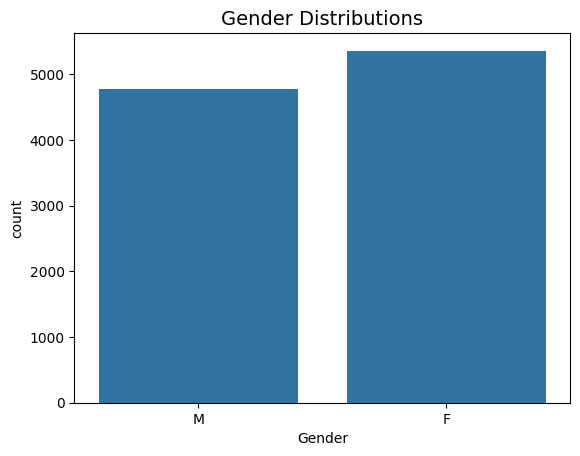

In [14]:
counts = data_copy['Gender'].value_counts()
print(counts)
sns.countplot(x='Gender', data=data_copy)
plt.title('Gender Distributions', fontsize=14)
plt.show()

La distribución por sexo presenta un número de muestras de mujeres que de hombres, pero la diferencia no es muy significativa. Podemos afirmar que la distribución es uniforme.

#### 6.1.2. Distribución de la caracteríatica Education_Level (Nivel de educación)

In [15]:
# Obtenemos el total y de niveles de educación y etiqueta
education_level_group, education_level_labels = getTotalCountAndLabelFromValueFeatureByGroup('Education_Level')

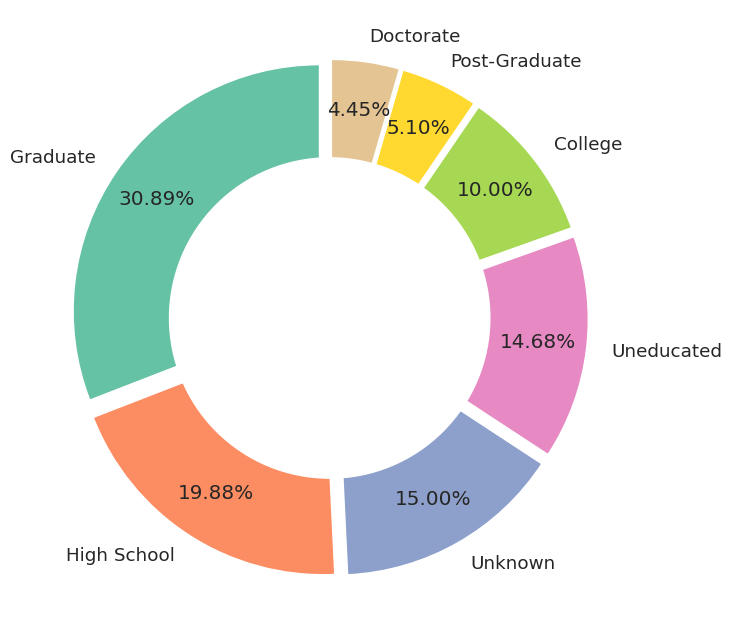

In [16]:

sns.set(font_scale = 1.2)
plt.figure(figsize=(8,8))

plt.pie(x= education_level_group,
        labels=education_level_labels,
        colors=sns.color_palette('Set2'),
        startangle=90,
        # show percentages
        autopct='%1.2f%%',
        # move the percentage inside the arcs
        pctdistance=0.80,
        # add space between the arcs
        explode=[0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
)

### Add a hole in the pie
hole = plt.Circle((0, 0), 0.65, facecolor='white')
plt.gcf().gca().add_artist(hole)

plt.show()


  El conjunto de datos presenta un 15% de clientes que desconocemos su nivel de estudios. Se puede dar el caso de que un número de clientes no hayan informado de este dato. Podemos afirmar que más del 70% de los clientes tiene un nivel de educación adecuado.

#### 6.1.3. Distribución de la caracteríatica Marital_Status (estado civil)

In [17]:
marital_status_group, marital_status_labels = getTotalCountAndLabelFromValueFeatureByGroup('Marital_Status')

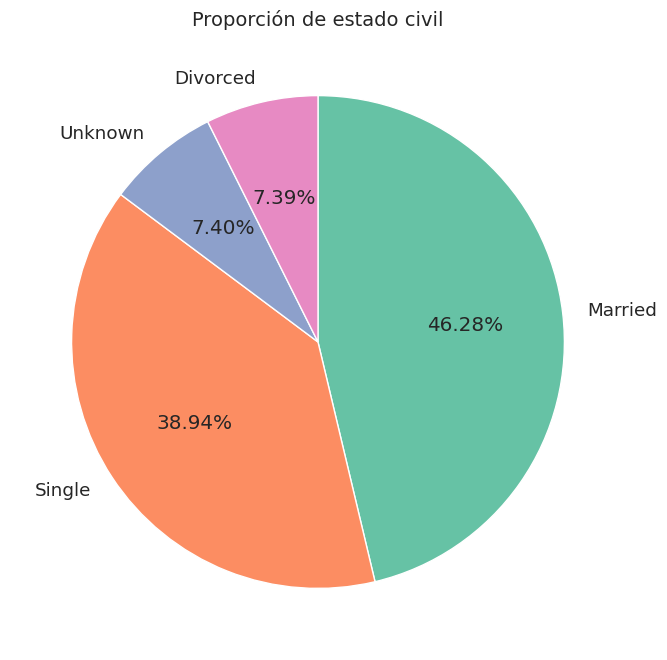

In [18]:

plt.figure(figsize=(8,8))
plt.pie(
    x=marital_status_group,
    labels=marital_status_labels,
    autopct='%1.2f%%',
    colors=sns.color_palette('Set2'),
    startangle=90,
    # plot slices clockwise
    counterclock=False
)
plt.title('Proporción de estado civil', fontsize=14)
plt.show()


Alrededor de los clientes del banco estan casados,la mitad que hay un grupo grande de clientes solteros. Curiosamente, alrededor de un 7% de clientes del banco estan divorciados. Es un dato muy curioso. También tenemos sobre un 7% de personas que no conocemos su estado civil.

#### 6.1.4. Distribución de la caracteríatica Income_Category (categoría de ingresos)

In [19]:
# Obtenemos los diferentes estados civiles agrupados
income_category_group, income_category_labels = getTotalCountAndLabelFromValueFeatureByGroup('Income_Category')

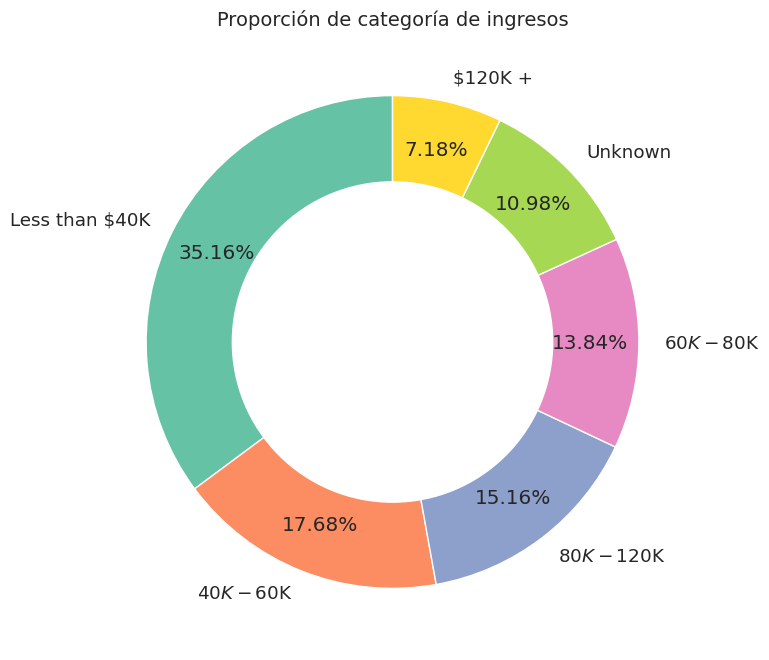

In [20]:
sns.set(font_scale = 1.2)
plt.figure(figsize=(8,8))

plt.pie(
    x=income_category_group, labels=income_category_labels,
    colors=sns.color_palette('Set2'),
    startangle=90,
    # show percentages
    autopct='%1.2f%%',
    # move the percentage inside the arcs
    pctdistance=0.80,

)

### Add a hole in the pie
hole = plt.Circle((0, 0), 0.65, facecolor='white')
plt.gcf().gca().add_artist(hole)
plt.title('Proporción de categoría de ingresos', fontsize=14)
plt.show()

#### 6.1.5. Distribución de la caracteríatica Card_Category (categoría de tarjeta)

In [21]:
card_category_group, card_category_labels = getTotalCountAndLabelFromValueFeatureByGroup('Card_Category')

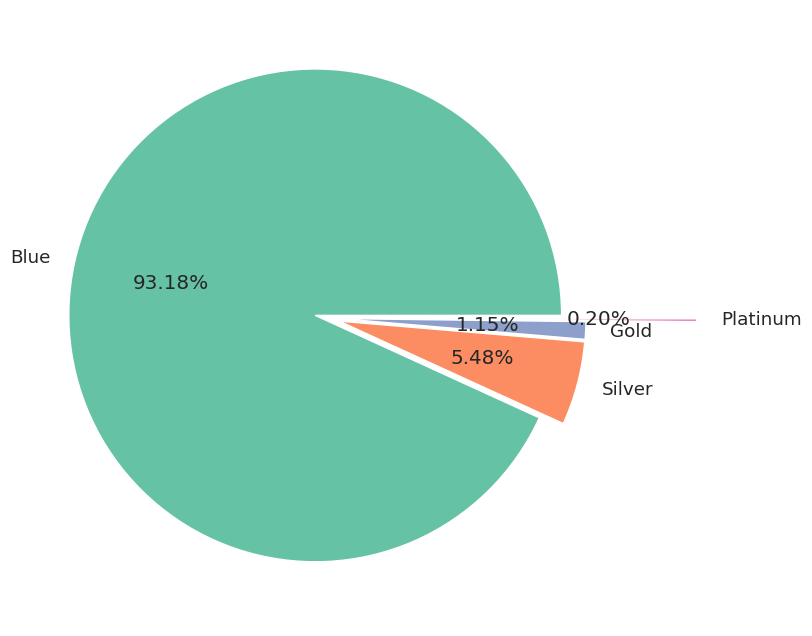

In [22]:
sns.set(font_scale = 1.2)
plt.figure(figsize=(8,8))

plt.pie(
    x=card_category_group,
    labels=card_category_labels,
    autopct='%1.2f%%',
    colors=sns.color_palette('Set2'),
    # Add space around each slice
    explode=[0.05, 0.05, 0.05, 0.5]
)

plt.show()


#### 6.1.6  Distribución de la caracteríatica Attrition_Flag. La variable objetivo (Clase)

In [23]:
attrition_flag_group, attrition_flag_labels = getTotalCountAndLabelFromValueFeatureByGroup('Attrition_Flag')

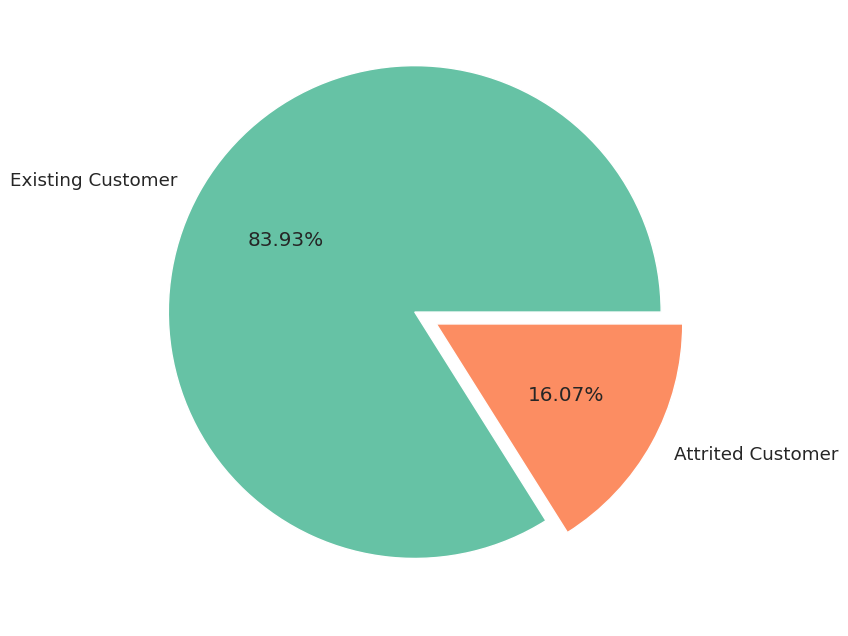

In [24]:
sns.set(font_scale = 1.2)
plt.figure(figsize=(8,8))

plt.pie(
    x=attrition_flag_group,
    labels=attrition_flag_labels,
    autopct='%1.2f%%',
    colors=sns.color_palette('Set2'),
    # Add space around each slice
    explode=[0.05, 0.05]
)

plt.show()

LA gráfica nos muestra una gran diferencia entre los clientes que abandonan con un 16.07% y los clientes que forman parte del banco con un 83.93%. Este indicador nos indica que los datos no están balanceados y deberemos utilizar técnicas como SMOTE para aumentar el tamaño de las muestras de clientes que abandonan con el fin de balancear los datos de la variable objetivo.

### 6.2. Exploración características numéricas

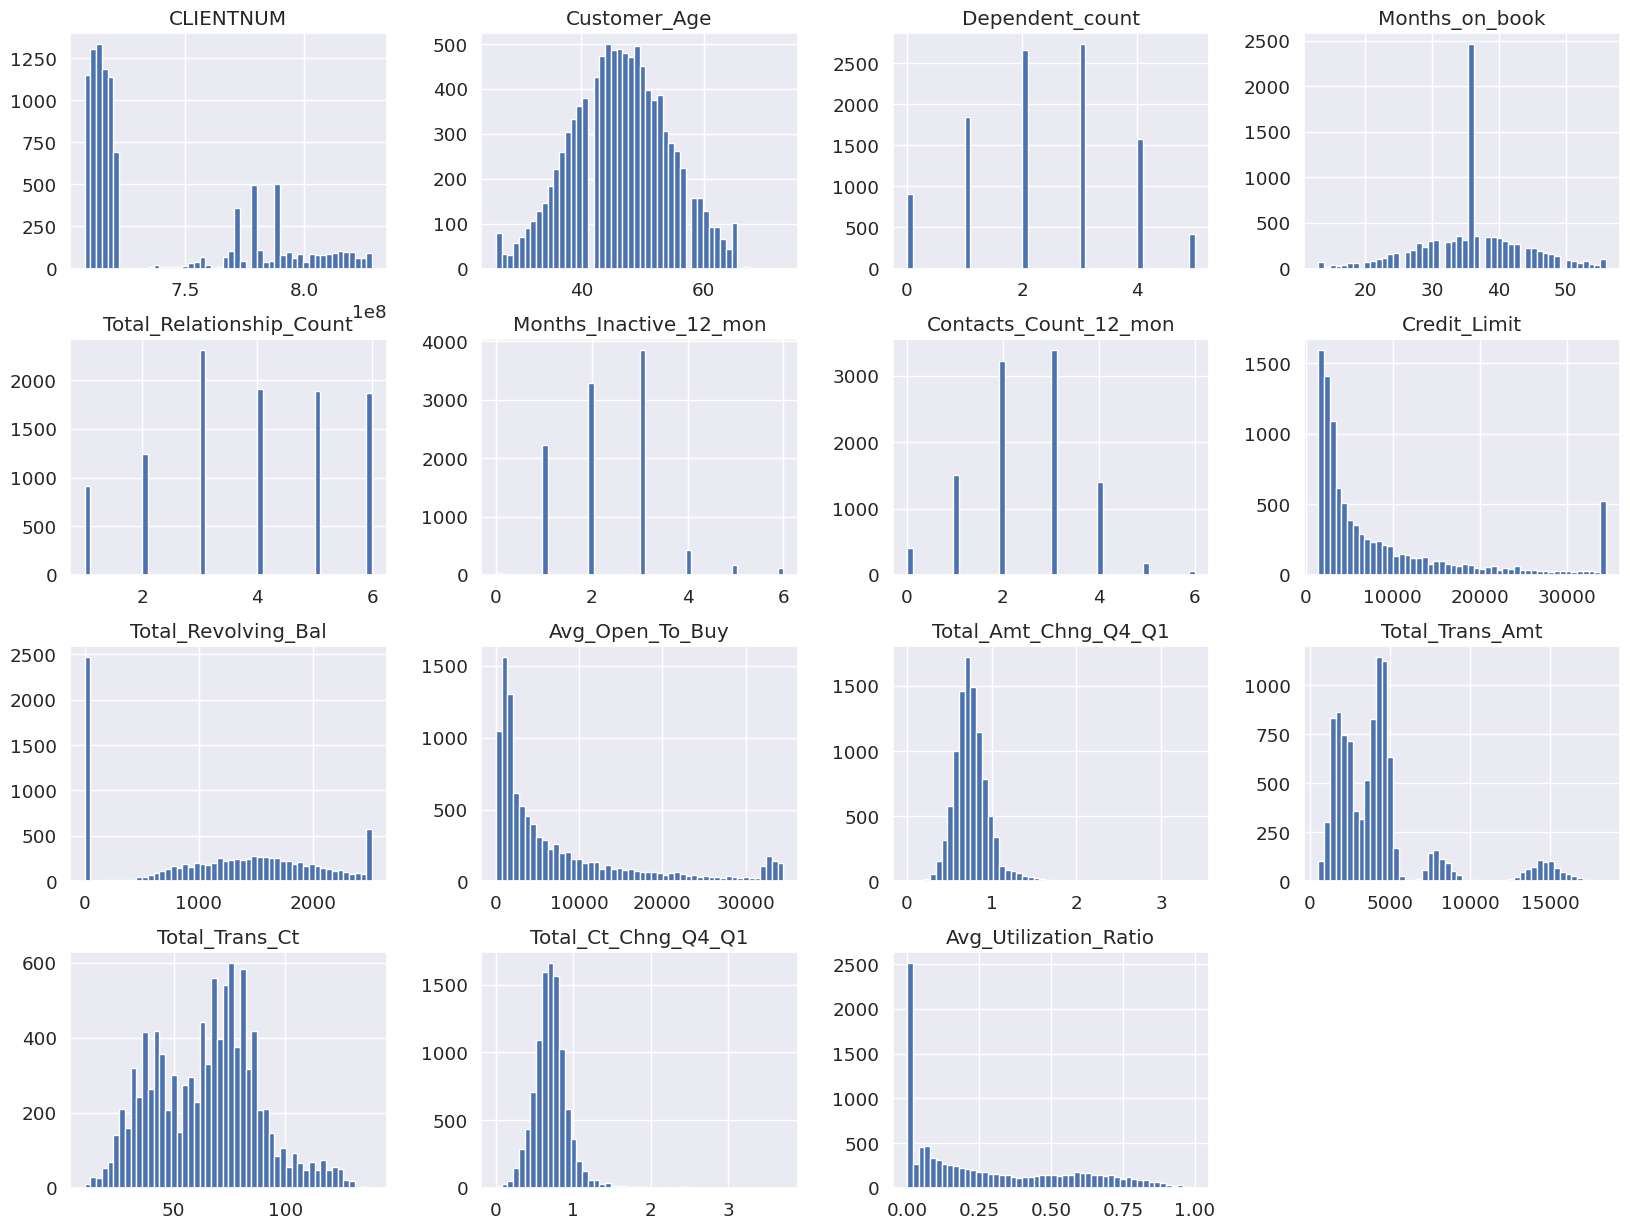

In [25]:
# Representar gráficamente la distribución de los atributos
data_copy.hist(bins=50, figsize=(20,15))
plt.show()

La distribución de la característica **Customer_Age**, presenta una distribución bastante normalidad. Podemos utilizar esta variable con una supuesta normalidad.




La característica **Months_on_book** presenta un pico agudo en el centro de la distribución y un número bajo de valores concentrados en torno a la media normal de la distribución normal. En consecuencia, tenemos un valor bajo de **curtosis** que indica una distribución con forma muy plana, lo que significa que no podemos asumir la normalidad de esta variable.






las distribuciones muy sesgadas utilizaremos técnicas de normalización o escalado para asemejarlas a una distribución normal. Esto ayudaría al rendimiento del modelo.

### 6.3. Gestión de Outliers

In [26]:
numeric_colums = data_copy.select_dtypes(exclude='object').columns

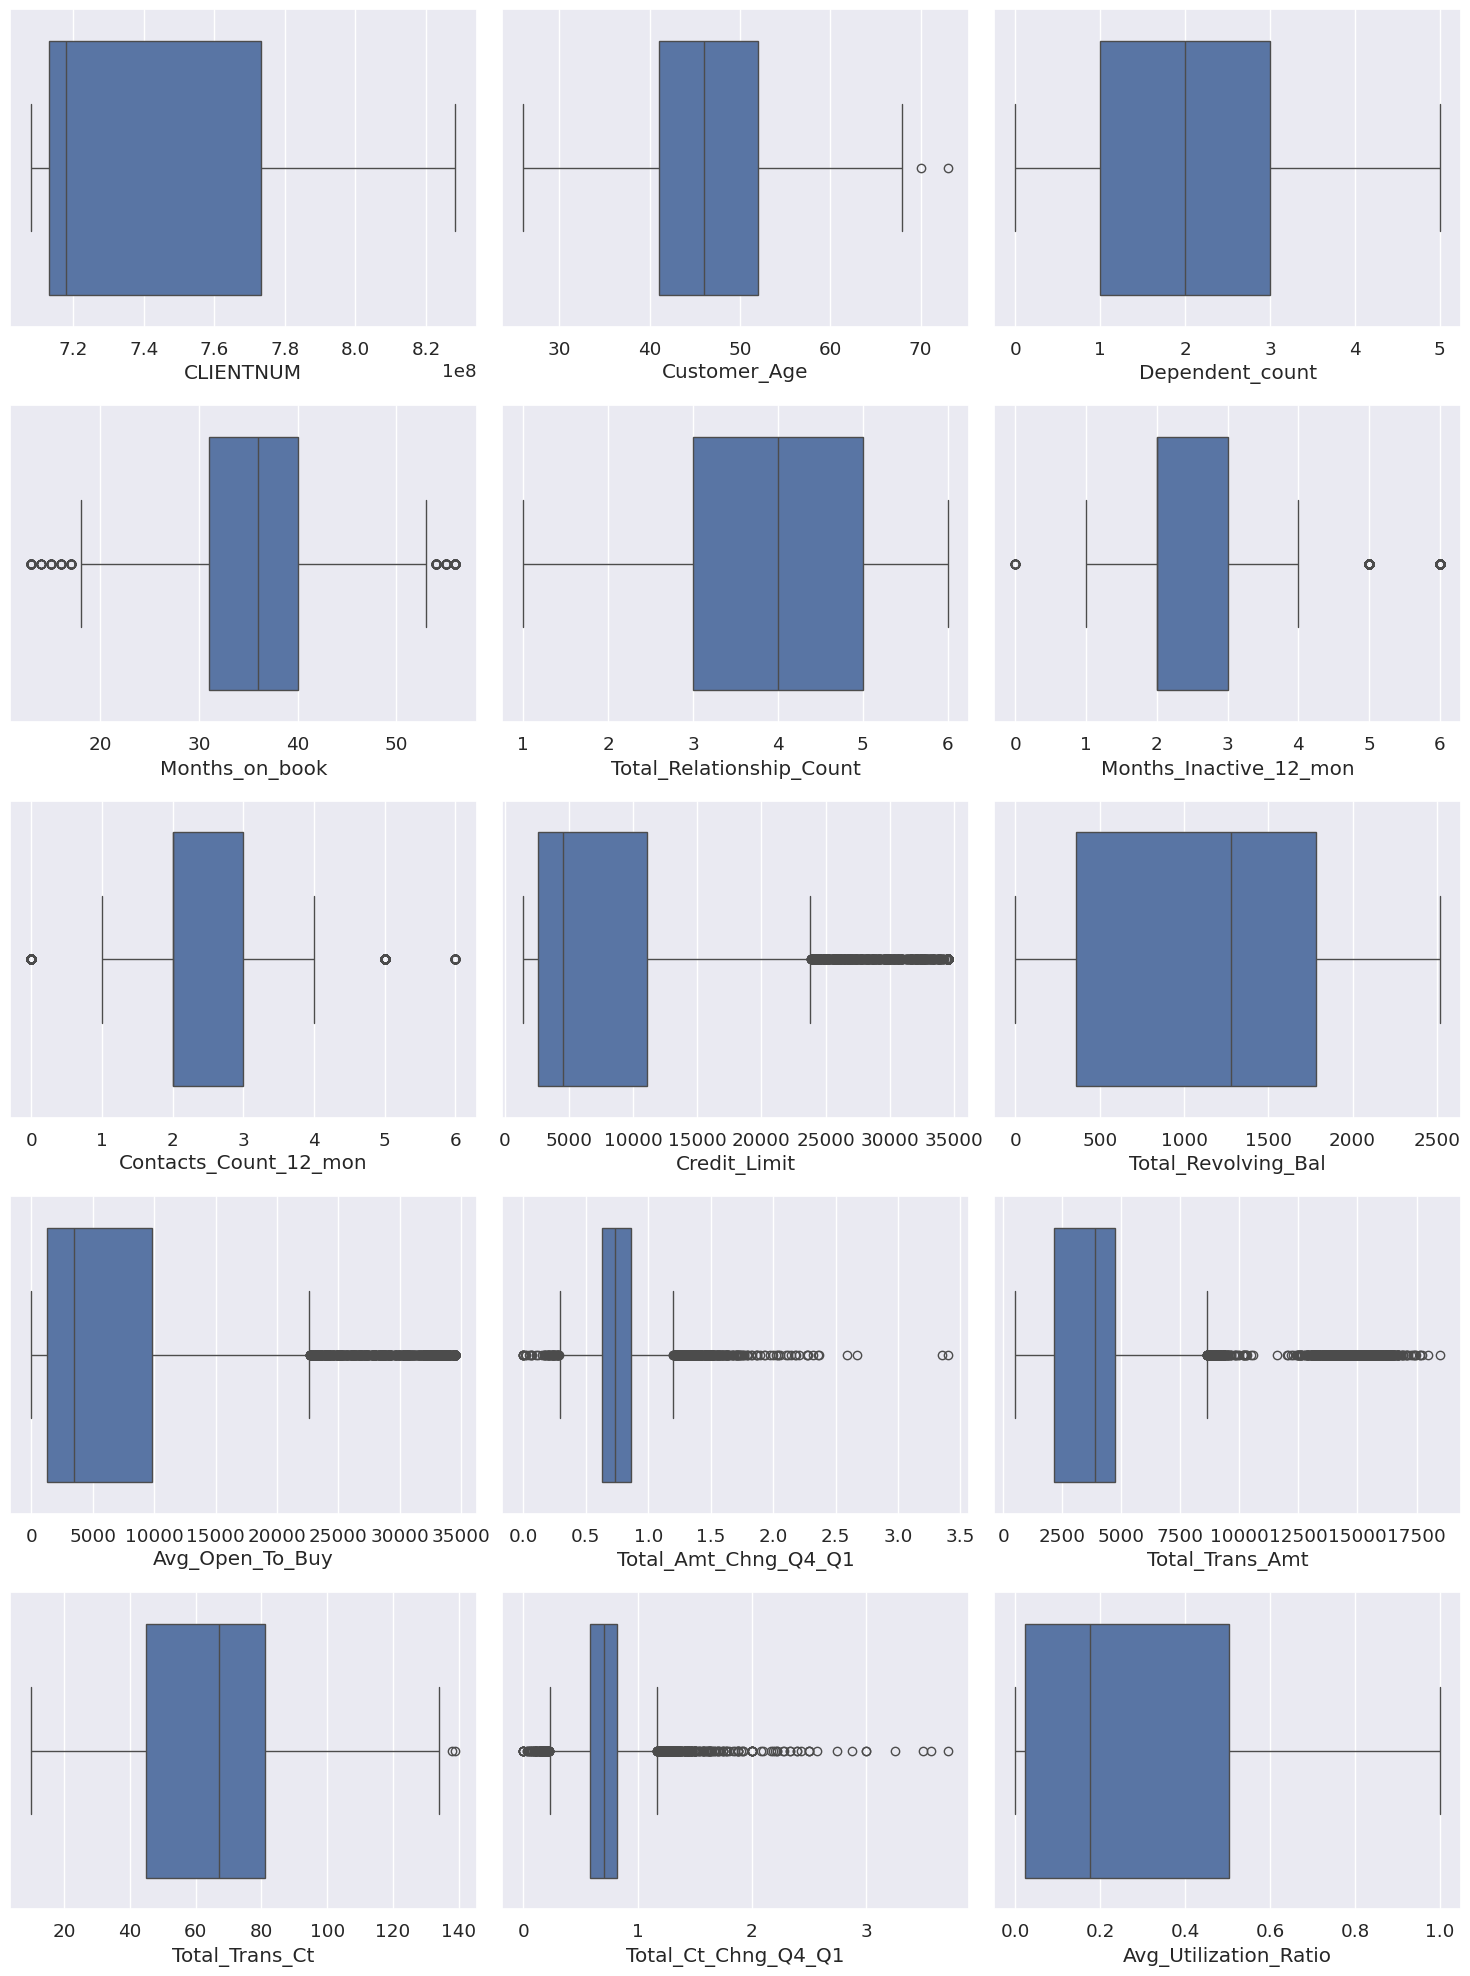

In [27]:
# Seleccionamos las variables
nrows, ncols = 5, 3
cols = data_copy.select_dtypes(exclude='object').columns

# Crea la figura y los ejes
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,20))
axes = axes.ravel()  # flattening the array makes indexing easier

for col, ax in zip(cols, axes):
    sns.boxplot(x=data_copy[col], ax=ax)

# Ajusta las gráficas
plt.tight_layout()
plt.show()

### 6.3 Corrrelación

Cuando existe correlación entre uno de los atributos o características de entrada y la variable de salida, quiere decir que básicamente ese atributo va a ser bastante útil y que va a ser significativo para tratar de clasificar en una categoría u otra los ejemplos que tenemos en nuestro conjunto de datos.

También podemos utilizarlo para medir la correlación que hay entre diferentes características de entrada, de manera que si una característica de entrada la otra también sube a lo mejor básicamente nos están proporcionando la misma intuición y entonces no necesitamos tener las dos características, porque están muy correlacionadas. Quizá podemos eliminar esa característica y dejar nuestro conjunto de datos con una característica menos lo cual sería menos complejo y exigiría menos recursos computacionales para entrenar nuestro algoritmo de Machine Learning.


In [28]:
data_copy.Attrition_Flag = data_copy.Attrition_Flag.factorize()[0]

data_copy_num = data_copy.select_dtypes(exclude='object')


In [29]:
# Mostrar la correlación entre los atributos del conjunto de datos
corr_matrix = data_copy_num.corr()
corr_matrix['Attrition_Flag'].sort_values(ascending=False)

,Attrition_Flag
Attrition_Flag,1.000000
Contacts_Count_12_mon,0.204491
Months_Inactive_12_mon,0.152449
Dependent_count,0.018991
Customer_Age,0.018203
Months_on_book,0.013687
Avg_Open_To_Buy,-0.000285
Credit_Limit,-0.023873
CLIENTNUM,-0.046430
Total_Amt_Chng_Q4_Q1,-0.131063


In [30]:
# Mostrar correlación lineal entre todos los atributos numéricos del conjunto de datos
data_copy_num.corr()

,CLIENTNUM,Attrition_Flag,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
CLIENTNUM,1.000000,-0.046430,0.007613,0.006772,0.134588,0.006907,0.005729,0.005694,0.005708,0.000825,0.005633,0.017369,-0.019692,-0.002961,0.007696,0.000266
Attrition_Flag,-0.046430,1.000000,0.018203,0.018991,0.013687,-0.150005,0.152449,0.204491,-0.023873,-0.263053,-0.000285,-0.131063,-0.168598,-0.371403,-0.290054,-0.178410
Customer_Age,0.007613,0.018203,1.000000,-0.122254,0.788912,-0.010931,0.054361,-0.018452,0.002476,0.014780,0.001151,-0.062042,-0.046446,-0.067097,-0.012143,0.007114
Dependent_count,0.006772,0.018991,-0.122254,1.000000,-0.103062,-0.039076,-0.010768,-0.040505,0.068065,-0.002688,0.068291,-0.035439,0.025046,0.049912,0.011087,-0.037135
Months_on_book,0.134588,0.013687,0.788912,-0.103062,1.000000,-0.009203,0.074164,-0.010774,0.007507,0.008623,0.006732,-0.048959,-0.038591,-0.049819,-0.014072,-0.007541
Total_Relationship_Count,0.006907,-0.150005,-0.010931,-0.039076,-0.009203,1.000000,-0.003675,0.055203,-0.071386,0.013726,-0.072601,0.050119,-0.347229,-0.241891,0.040831,0.067663
Months_Inactive_12_mon,0.005729,0.152449,0.054361,-0.010768,0.074164,-0.003675,1.000000,0.029493,-0.020394,-0.042210,-0.016605,-0.032247,-0.036982,-0.042787,-0.038989,-0.007503
Contacts_Count_12_mon,0.005694,0.204491,-0.018452,-0.040505,-0.010774,0.055203,0.029493,1.000000,0.020817,-0.053913,0.025646,-0.024445,-0.112774,-0.152213,-0.094997,-0.055471
Credit_Limit,0.005708,-0.023873,0.002476,0.068065,0.007507,-0.071386,-0.020394,0.020817,1.000000,0.042493,0.995981,0.012813,0.171730,0.075927,-0.002020,-0.482965
Total_Revolving_Bal,0.000825,-0.263053,0.014780,-0.002688,0.008623,0.013726,-0.042210,-0.053913,0.042493,1.000000,-0.047167,0.058174,0.064370,0.056060,0.089861,0.624022


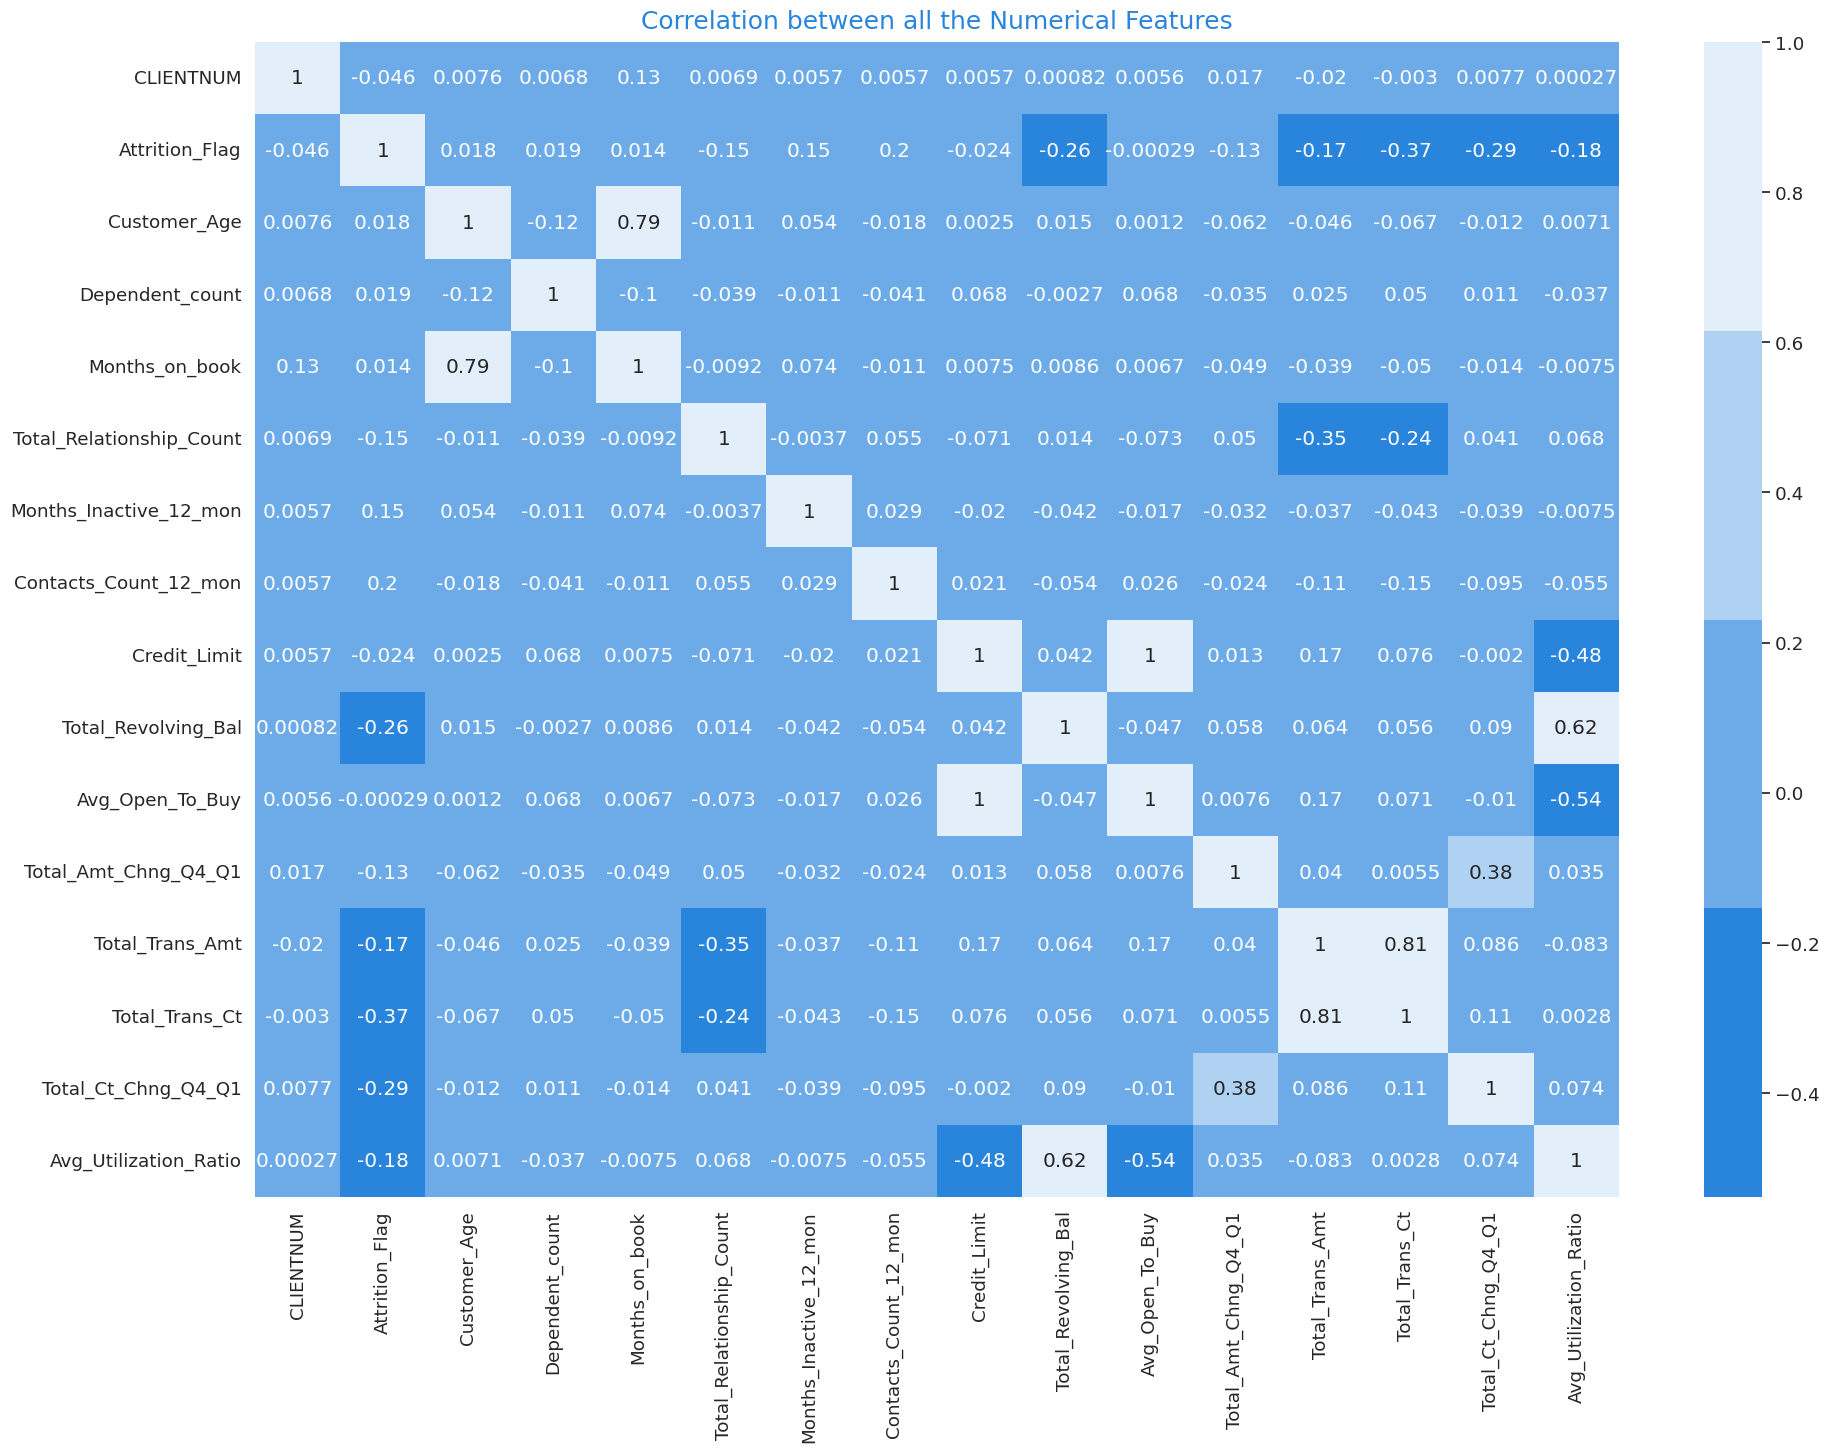

In [31]:
# Representar gráficamente la matriz de correlación
corr = data_copy_num.corr()

plt.figure(figsize=[22,15])
plt.title("Correlation between all the Numerical Features", size=18, pad=10, color='#2985dc')
sns.heatmap(corr, cmap=['#2985dc', '#6cabe7','#b0d2f2','#e2effa'], annot=True)
plt.show()

## 7. División de los datos

Antes de comenzar, vamos a recuperar el conjunto de datos limpio y vamos a separar las etiquetas del resto de los datos, no necesariamente queremos aplicar las mismas transformaciones en ambos conjuntos.

In [32]:
data.Attrition_Flag = data.Attrition_Flag.factorize()[0]
data.Gender = data.Gender.factorize()[0]

In [33]:
train_set, val_set, test_set = train_val_test_split(data, stratify="Attrition_Flag")

In [34]:
print("Longitud del Training Set:", len(train_set))
print("Longitud del Validation Set:", len(val_set))
print("Longitud del Test Set:", len(test_set))

Longitud del Training Set: 6076
Longitud del Validation Set: 2025
Longitud del Test Set: 2026


In [35]:
# Separamos las características de entrada de la característica de salida
X_train = train_set.drop("Attrition_Flag", axis=1)
y_train = train_set["Attrition_Flag"].copy()

X_val = val_set.drop("Attrition_Flag", axis=1)
y_val = val_set["Attrition_Flag"].copy()

X_test = test_set.drop("Attrition_Flag", axis=1)
y_test = test_set["Attrition_Flag"].copy()

## 8. Preprocesado de los datos

### 8.1. Transformar las variables categóricas y escalado de los datos

In [36]:
# Columnas categóricas y numéricas
cat_cols = X_train.select_dtypes(include='object').columns
num_cols = X_train.select_dtypes(exclude='object').columns

# ColumnTransformer datos numéricos escalados
preprocessor = ColumnTransformer(transformers=[
    ('num', RobustScaler(), num_cols),
    ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), cat_cols)
])

# Para árboles → no escalamos numéricas
preprocessor_noscale = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)

In [37]:
# Aplicar solo preprocesamiento para datos escalados
X_train_scaled = preprocessor.fit_transform(X_train)
X_val_scaled   = preprocessor.transform(X_val)
X_test_scaled  = preprocessor.transform(X_test)

In [38]:
# Aplicar solo preprocesamiento para no escalados
X_train_noscale = preprocessor_noscale.fit_transform(X_train)
X_val_noscale   = preprocessor_noscale.transform(X_val)
X_test_noscale  = preprocessor_noscale.transform(X_test)

### 8.2. Generación de datos sintéticos

SMOTE (Synthetic Minority Over-sampling Technique) genera nuevas muestras sintéticas a partir de los datos existentes, específicamente del conjunto minoritario. Si aplicamos SMOTE antes de la división:

Riesgo de data leakage (fugas de información): Las observaciones sintéticas generadas por SMOTE se basan en los datos de entrada originales. Si aplicas SMOTE antes de la división, esas muestras sintéticas (derivadas de ejemplos que luego estarán en test o validación) pueden contaminar el set de entrenamiento.

Evaluaciones poco realistas: Los modelos pueden parecer que generalizan bien, pero en realidad están entrenando y validando sobre datos demasiado similares, invalidando las métricas.

SMOTE se basa en distancias entre puntos en el espacio de features, crea muestras sintéticas a partir de los **datos de entrenamiento**. Lo ideal es aplicar escalado antes de generar las muestras sintéticas.

Si aplicamos SMOTE en los datos de validación o test, estaremos alterando los datos reales y ayudando artificialmente al modelo. Por este motivo es importante no aplicar la técnica SMOTE en los datos de validación y test.



In [39]:
# Aplicar SMOTE solo en el entrenamiento
smote = SMOTE(random_state=42)

# Datos de entrenamiento balanceado (SMOTE + escalados)
X_train_scaled_balanced, y_train_scaled_balanced = smote.fit_resample(X_train_scaled, y_train)

# Datos de entrenamiento NO escalados
#X_train_noscale_balanced, y_train_noscale_balanced = smote.fit_resample(X_train_noscale, y_train)

In [40]:
count_y_train_pre_balanced = y_train_scaled_balanced.value_counts()
print(count_y_train_pre_balanced)

Attrition_Flag
0    5100
1    5100
Name: count, dtype: int64


In [41]:
#count_y_train_noscale_balanced = y_train_noscale_balanced.value_counts()
#print(count_y_train_noscale_balanced)

### 8.3. Valores nulos

In [42]:
# Comprobamos si hay valores nulos en el conjunto de datos de entrenamiento
is_null = np.isnan(X_train_scaled_balanced)
print(is_null[is_null])

[]


In [43]:
# Comprobamos si hay valores nulos en el conjunto de datos de validación
is_null =  np.isnan(X_val_scaled)
print(is_null[is_null])

[]


In [44]:
# Comprobamos si hay valores nulos en el conjunto de datos de prueba
is_null = np.isnan(X_test_scaled)
print(is_null[is_null])

[]


Los tres subconjuntos de datos no presentan datos faltantes (nulos).

## 8. Modelado

### 8.1. Selección de modelos

#### 8.1.1. Regresión logística

In [45]:
clf = LogisticRegression()
clf.fit(X_train_scaled_balanced, y_train_scaled_balanced)

LogisticRegression()

In [46]:
y_pred = clf.predict(X_val_scaled)

In [47]:
print('Accuracy: {:.3f}'.format(accuracy_score(y_val, y_pred)))

Accuracy: 0.844


### 8.1.2. Random Forest

In [48]:
# Modelo entrenado con el conjunto de datos No escalados
clf_rnd = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
clf_rnd.fit(X_train_noscale, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [49]:
# Modelo entrenado con el conjunto de datos balanceados (SMOTE) + escalado
clf_rnd_scaled = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
clf_rnd_scaled.fit(X_train_scaled_balanced, y_train_scaled_balanced)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [50]:
# Predecimos con el conjunto de datos de entrenamiento
y_train_pred = clf_rnd.predict(X_train_noscale)
y_train_prep_pred = clf_rnd_scaled.predict(X_train_scaled_balanced)

In [51]:
# Comparamos resultados entre escalado y sin escalar
evaluate_result(y_train_pred, y_train, y_train_prep_pred, y_train_scaled_balanced, f1_score)

f1_score WITHOUT preparation: 1.0
f1_score WITH preparation: 1.0


In [52]:
# Predecimos con el conjunto de datos de validación
y_pred = clf_rnd.predict(X_val_noscale)
y_prep_pred = clf_rnd_scaled.predict(X_val_scaled)

In [53]:
# Comparamos resultados entre escalado y sin escalar
evaluate_result(y_pred, y_val, y_prep_pred, y_val, f1_score)

f1_score WITHOUT preparation: 0.9540492156375373
f1_score WITH preparation: 0.951080753698981


SMOTE depende del escalado, porque genera nuevas instancias en el espacio de características a partir de distancias (usando KNN por defecto). Al presentar variables con  magnitudes muy diferentes, sin escalado SMOTE podría generar puntos sintéticos poco realistas, porque las variables de gran magnitud dominan el cálculo de distancia.

Este puede ser el motivo de que el F1 score mejora para los datos de entrenamiento que han sido escalados con un 94,45% de predicción.

#### 8.1.3. Clasificación XGBoost

In [54]:
# Modelo entrenado con el conjunto de datos sin balancear
clf_xgb = XGBClassifier(objective="binary:logistic", random_state=42, n_jobs=-1)
clf_xgb.fit(X_train_noscale, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=-1, num_parallel_tree=None, ...)

In [55]:
# Modelo entrenado con el conjunto de datos balanceados (SMOTE + escalados)
clf_xgb_scaled = XGBClassifier(objective="binary:logistic", random_state=42, n_jobs=-1)
clf_xgb_scaled.fit(X_train_scaled_balanced, y_train_scaled_balanced)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=-1, num_parallel_tree=None, ...)

In [56]:
# Predecimos con el conjunto de datos de entrenamiento
y_train_pred = clf_xgb.predict(X_train_noscale)
y_train_prep_pred = clf_xgb_scaled.predict(X_train_scaled_balanced)

In [57]:
# Comparamos resultados entre escalado y sin escalar
evaluate_result(y_train_pred, y_train, y_train_prep_pred, y_train_scaled_balanced, f1_score)

f1_score WITHOUT preparation: 1.0
f1_score WITH preparation: 1.0


In [58]:
# Predecimos con el conjunto de datos de validación
y_pred = clf_xgb.predict(X_val_noscale)
y_prep_pred = clf_xgb_scaled.predict(X_val_scaled)

In [59]:
# Comparamos resultados entre escalado y sin escalar
evaluate_result(y_pred, y_val, y_prep_pred, y_val, f1_score)

f1_score WITHOUT preparation: 0.9666765039370179
f1_score WITH preparation: 0.9625160218027159


### 8.2. Fine Tunning Xgboost

In [60]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, make_scorer

param_grid = {
    'n_estimators': [300, 400, 500],
    'max_depth': [7, 9, 11],
    'learning_rate': [0.1, 0.125, 0.5]}

# Configurar validación cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

xgb_clf = XGBClassifier(objective="binary:logistic", random_state=42, n_jobs=-1)

# train across 5 folds, that's a total of 6*2=12 rounds of training
grid_search = GridSearchCV(xgb_clf,
                           param_grid,
                           cv=cv,
                           #scoring=make_scorer(f1_score),
                           scoring='f1',
                           return_train_score=True)

grid_search.fit(X_train_scaled_balanced, y_train_scaled_balanced)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, feature_weights=None,
                                     gamma=None, grow_polic...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=-1, num_parallel_tree=None, ...),
             param_grid={'learning_rate': [0.1, 0.125, 0.5],
                         'max_depth': [7, 9, 11],
                         'n_estimators': [300, 400, 500]},
             return_train_score=True, scoring='f1')

In [63]:
print("Mejores parámetros:", grid_search.best_params_)
print(f"Mejor F1 score:: {grid_search.best_score_}")

Mejores parámetros: {'learning_rate': 0.125, 'max_depth': 9, 'n_estimators': 300}
Mejor F1 score:: 0.9844489825531617


### 8.3. Predicción y métricas de evaluación: Xgboost

In [64]:
best_model = grid_search.best_estimator_

# Save best model
best_model.save_model("best_model_churn.ubj")

# Load save model
loaded_model = XGBClassifier()
loaded_model.load_model("best_model_churn.ubj")

# Predicción
y_pred = loaded_model.predict(X_val_scaled)
# Predict the probabilities for the test set
y_probs = loaded_model.predict_proba(X_val_scaled)[:, 1]


# Evaluaciñon de métricas
f1 = f1_score(y_val, y_pred)
accuracy= accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)

# Calculo de AUC - ROC score
roc_auc = roc_auc_score(y_val, y_probs)

# Print the metrics
print(f"AUC - ROC Score: {roc_auc:.2f}")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

AUC - ROC Score: 0.99
Accuracy: 0.96
Precision: 0.88
Recall: 0.89
F1 Score: 0.89


### 8.4. Matríz de confusión: Xgboost

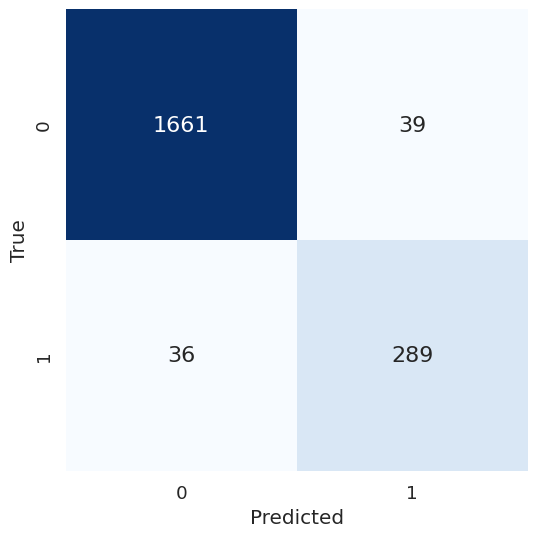

In [65]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_val, y_pred)
cm_df = pd.DataFrame(cm, index=[0, 1], columns= [0, 1])
cm_df.index.name = 'True'
cm_df.columns.name = 'Predicted'

plt.figure(figsize=(6,6))
ax=sns.heatmap(cm_df, # Visualizando la matriz de confusion
               annot=True,
               fmt="d",       # formato correcto
               cmap='Blues',
               cbar=False,
               square=True,
               annot_kws={'fontsize':16})


### 8.5. Curva de AUC-ROC: Xgboost

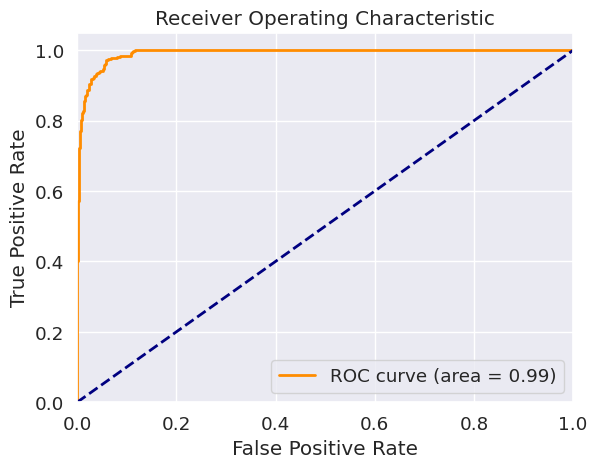

In [66]:
# Plotting the ROC Curve
fpr, tpr, thresholds = roc_curve(y_val, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## 9. Características importantes

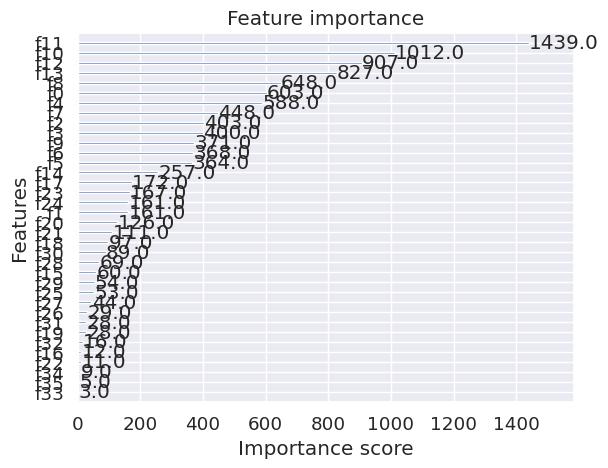

In [68]:
from xgboost import plot_importance


# Plot feature importances
plot_importance(loaded_model)
plt.show()

                          feature  importance
12            num__Total_Trans_Ct    0.255841
34    cat__Card_Category_Platinum    0.088786
8        num__Total_Revolving_Bal    0.083972
4   num__Total_Relationship_Count    0.069570
11           num__Total_Trans_Amt    0.062807
13       num__Total_Ct_Chng_Q4_Q1    0.037561
1                     num__Gender    0.028140
5     num__Months_Inactive_12_mon    0.024092
23    cat__Marital_Status_Married    0.021991
10      num__Total_Amt_Chng_Q4_Q1    0.018968


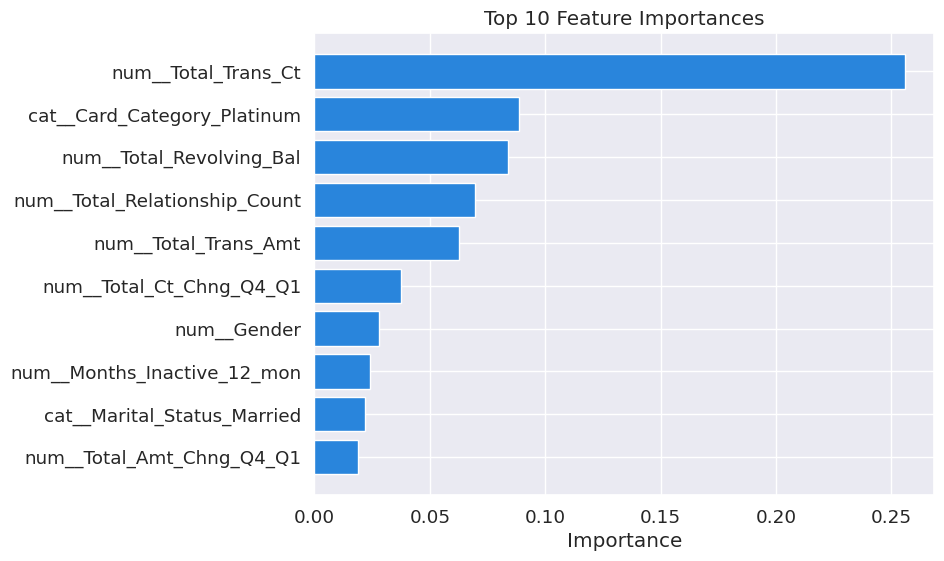

In [71]:


feature_names_original = data.drop('Attrition_Flag', axis=1).columns

# Supongamos que tu preprocesador es ColumnTransformer o OneHotEncoder
feature_names_transformed = preprocessor.get_feature_names_out()

# Reconstruir el DataFrame usado en el modelo
# X_train_scaled_balanced es el array que pasaste al fit del modelo
X_model_df = pd.DataFrame(X_train_scaled_balanced, columns=feature_names_transformed)

# Obtener importancias del mejor modelo
importances = loaded_model.feature_importances_

# Crear DataFrame con importancias asociadas a los nombres reales
feature_importances = pd.DataFrame({
    'feature': feature_names_transformed,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Mostrar top 10 características
print(feature_importances.head(10))

# Graficar
import matplotlib.pyplot as plt

top_features = feature_importances.head(10)
plt.figure(figsize=(8,6))
plt.barh(top_features['feature'], top_features['importance'], color='#2985dc')
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("Top 10 Feature Importances")
plt.show()
